We would like to determine the appropriate value of $c$ for varying recombination rates under the influenza coalescence model. This needs to be redetermined when segment trees and recombination events are simulated using an 8-segment ARG diverging in time. The parameter $c$ determines the if a branch should be removed from the simulated trees to make simulated trees more similar to actual input trees. Normally, reconstructed influenza trees are not fully resolved, i.e. they are not binary and most internal nodes have more than two children. One way to measure resolution is the resolution rate or the proportion of internal nodes (plus 1) to leaves in a tree. A full resolved tree with $n$ leaves has $n-1$ internal branches, thus the resolution rate of a fully resolved tree is 1. Short branches are more likely to not have mutations and to not be part of a reconstructed tree topology. A branch is removed with probability $$exp(-\tau/(c*N)),$$ where $\tau$ in the branch length in generations (this is scaled by the population size $N$), thus for larger c less branches are removed. Additionally, branch length does not only depend on population size but also coalescence rate, which in both the flu and kingman model is dependent on the number of leaves in a tree.

Furthermore, as Pierre showed, in the flu coalescence model average branch length in an average segment tree increases as recombination rate increases. Thus to have segment trees resolved at the same rate for different recombination rates under the flu model, a larger $c$ must be chosen for higher recombination rates. Here I shall explore that relationship.

I use the 6y europe raw flu dataset (from the seasonal flu build) and the NY data set as two examples for typical resolution in flu trees.

In [89]:
using MTKTools

get_real_MCCs (generic function with 1 method)

In [90]:
using TreeKnit, TreeTools, StatsBase, Random
t1 = read_tree("$(dirname(pathof(TreeKnit)))/../test/NYdata/tree_ha.nwk")
t2 = read_tree("$(dirname(pathof(TreeKnit)))/../test/NYdata/tree_na.nwk")
t1 = copy(convert(Tree{TreeTools.MiscData}, t1))
t2 = copy(convert(Tree{TreeTools.MiscData}, t2))
res_HA_NY = TreeKnit.resolution_value(t1)
res_NA_NY = TreeKnit.resolution_value(t2)
print("#nodes(HA) in NY data set: "*string(length(t1.lleaves))*"\n")
print("#nodes(NA) in NY data set: "*string(length(t2.lleaves))*"\n")
print("NA: resolution in NY data: "*string(res_NA_NY)*"\n")
print("HA: resolution in NY data: "*string(res_HA_NY)*"\n")

#nodes(HA) in NY data set: 154
#nodes(NA) in NY data set: 154
NA: resolution in NY data: 0.3006535947712418
HA: resolution in NY data: 0.29411764705882354


In [91]:
tnext_HA = read_tree(pwd()*"/Influenza_trees/tree_rawHA.nwk")
res_HA = TreeKnit.resolution_value(tnext_HA)
tnext_NA = read_tree(pwd()*"/Influenza_trees/tree_rawNA.nwk")
res_NA = TreeKnit.resolution_value(tnext_NA)
print("#nodes(HA) in europe (6y) data set: "*string(length(tnext_HA.lleaves))*"\n")
print("#nodes(NA) in europe (6y) data set: "*string(length(tnext_NA.lleaves))*"\n")
print("NA: resolution in europe (6y) data: "*string(res_NA)*"\n")
print("HA: resolution in europe (6y) data: "*string(res_HA)*"\n")

#nodes(HA) in europe (6y) data set: 1994
#nodes(NA) in europe (6y) data set: 1994
NA: resolution in europe (6y) data: 0.4305067737079779
HA: resolution in europe (6y) data: 0.4305067737079779


I then perform 8-segment ARG simulations for different recombination rates, where I remove branches using a randomly chosen value of $c$ in the range $[0.2, 4.2]$. I start with trees with 154 leaves (to be comparable with the NY data set).

In [92]:
function find_c(;repeat=500, rec_rate = 1, n_nodes=154)
    res_values = Float32[]
    c_values = Float32[]
    for r in 1:repeat 
        rec = 10^rec_rate
        c=0.2 + 4*rand()
        trees, arg = get_trees(8, n_nodes, remove=true, c =c, ρ = rec);
        rand_ = sample(1:8, 2, replace=false)
        res = [TreeTools.resolution_value(t) for t in trees[rand_]]
        push!(res_values, sum(res)/2)
        push!(c_values, c)
    end
    return res_values, c_values
end

ran = -4:0.25:0
res_values = Dict()
c_values = Dict() 
for rec_rate in ran
    res_values[rec_rate], c_values[rec_rate] = find_c(rec_rate=rec_rate)
end

Now it would make sense to see if we can find a relationship between $c$ and the resolution rate - I can try this by fitting various functions to the data. An exponential fit appears to better describe the relationship for both high and low recombination rate than a polynomial fit.

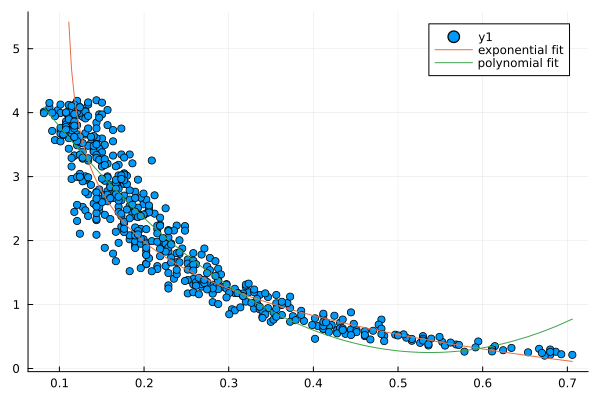

In [93]:
using Plots
using CurveFit

value = -4.0
scatter(res_values[value], c_values[value])
fit = curve_fit(LinearFit, res_values[value], ℯ.^-c_values[value])
y0b = max.(0, fit.(sort(res_values[value])))
plot!(sort(res_values[value]), -log.(y0b), label="exponential fit")
fit = curve_fit(Polynomial, res_values[value], c_values[value], 2)
y0b = fit.(sort(res_values[value]))
plot!(sort(res_values[value]), y0b, label="polynomial fit")


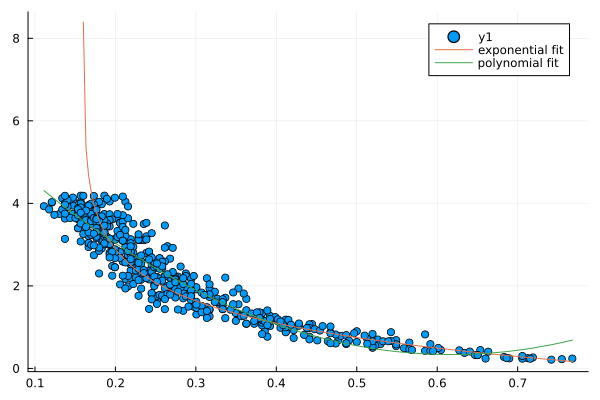

In [94]:
value = -0.5
plot(scatter(res_values[value], c_values[value]))
fit = curve_fit(LinearFit, res_values[value], ℯ.^-c_values[value])
y0b = max.(0, fit.(sort(res_values[value])))
plot!(sort(res_values[value]), -log.(y0b), label="exponential fit")
fit = curve_fit(Polynomial, res_values[value], c_values[value], 2)
y0b = fit.(sort(res_values[value]))
plot!(sort(res_values[value]), y0b, label="polynomial fit")


I can now calculate the exponential fit for all recombination values and evaluate the same resolution values at all such points to plot expected $c$ values that would produce the desired resolution rate when simulating input trees.

In [95]:
ran = -4:0.25:0
x = res_values[0.0]
function get_fits(ran)
    fits = Dict()
    for rec_rate in ran
        fit = curve_fit(LinearFit, res_values[rec_rate], ℯ.^-c_values[rec_rate])
        y = max.(0, fit.(x))
        fits[rec_rate] = fit
    end
    return fits
end
fits = get_fits(ran)

Dict{Any, Any} with 17 entries:
  -1.75 => LinearFit{Float32}((-0.16477, 1.4967))
  -3.0  => LinearFit{Float32}((-0.165006, 1.49105))
  0.0   => LinearFit{Float32}((-0.331706, 1.34127))
  -1.25 => LinearFit{Float32}((-0.178859, 1.48442))
  -1.0  => LinearFit{Float32}((-0.183791, 1.45672))
  -2.0  => LinearFit{Float32}((-0.166079, 1.48589))
  -0.25 => LinearFit{Float32}((-0.270192, 1.37082))
  -0.5  => LinearFit{Float32}((-0.222104, 1.38842))
  -3.25 => LinearFit{Float32}((-0.158184, 1.47484))
  -3.5  => LinearFit{Float32}((-0.159211, 1.47526))
  -2.25 => LinearFit{Float32}((-0.166283, 1.49517))
  -3.75 => LinearFit{Float32}((-0.170543, 1.52063))
  -2.5  => LinearFit{Float32}((-0.163574, 1.48645))
  -0.75 => LinearFit{Float32}((-0.199393, 1.45422))
  -1.5  => LinearFit{Float32}((-0.175602, 1.51779))
  -4.0  => LinearFit{Float32}((-0.162029, 1.4982))
  -2.75 => LinearFit{Float32}((-0.161011, 1.49707))

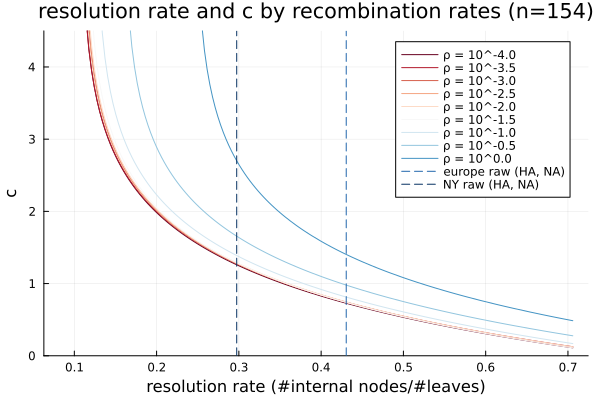

In [96]:
using DataFrames
function plot_res_c_by_rec(fits; n=154)
    value = -4.0
    x = sort(res_values[value])
    y0b = Vector{Float32}[]
    for rec_rate in -4:0.5:0
        fit =fits[rec_rate]
        y = max.(0, fit.(x))
        append!(y0b, [-log.(y)])
    end
    colnames = ["ρ = 10^"*string(r) for r in -4:0.5:0]
    df = DataFrame(y0b, :auto)
    rename!(df, Symbol.(colnames))
    my_cgrad = cgrad(:thermal, rev = true)
    p = plot(x, Matrix(df), xlabel="resolution rate (#internal nodes/#leaves)", ylabel="c", label =hcat(names(df)...), title="resolution rate and c by recombination rates (n="*string(n)*")", palette = :RdBu, ylim=(0, 4.5))
    plot!([(res_NA+res_HA)/2], seriestype="vline", label="europe raw (HA, NA)", linestyle=:dash)
    plot!([(res_NA_NY+res_HA_NY)/2], seriestype="vline", label="NY raw (HA, NA)", linestyle=:dash)
end
plot_res_c_by_rec(fits)

Furthermore, for a desired resolution rate it is possible to find the $c$ for each recombination rate individually using the previously fit or even to determine a function for each resolution rate, which given the recombination rate will output the required $c$.

In [97]:
res_154 = (res_NA_NY+res_HA_NY)/2
ran = -4:0.25:0
c_ = []
for rec_rate in ran
    fit = fits[rec_rate]
    append!(c_, -log.(max.(0, fit.(res_154))))
end

I note that the cut at resolution rate 0.297 is very similar to a scaled exponential function i.e. $c(r) = a*A^r + b$, with $c(r=0) = a + b$, $c(r = -4) \approx b$ and $\frac{(c(r) - b)}{c'(r)/r} = \frac{a*A^r}{a* A^{(r-1)}} = A$.

Now we can repeat the process for n=1994 to see if the results are different - I shall perform less simulations due to time constraints.

In [98]:
ran = -4:0.5:0
res_values = Dict()
c_values = Dict() 
for rec_rate in ran
    res_values[rec_rate], c_values[rec_rate] = find_c(;repeat=100, rec_rate = rec_rate, n_nodes=1994)
end

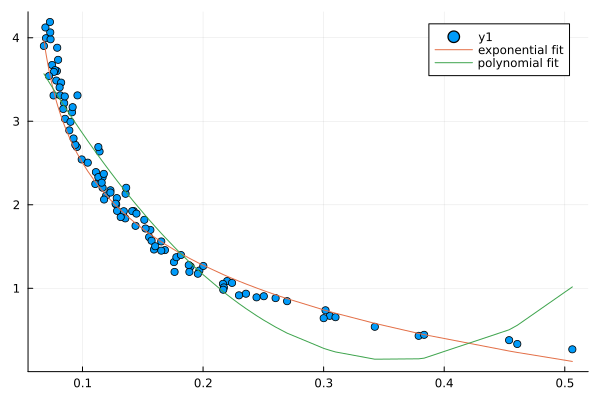

In [99]:
value = -4.0
plot(scatter(res_values[value], c_values[value]))
fit = curve_fit(LinearFit, res_values[value], ℯ.^-c_values[value])
y0b = max.(0, fit.(sort(res_values[value])))
plot!(sort(res_values[value]), -log.(y0b), label="exponential fit")
fit = curve_fit(Polynomial, res_values[value], c_values[value], 2)
y0b = fit.(sort(res_values[value]))
plot!(sort(res_values[value]), y0b, label="polynomial fit")

The fit appears good for resolution rates above 0.175 - below this value I would question the fit.

In [100]:
ran = -4:0.5:0
fits = get_fits(ran)

Dict{Any, Any} with 9 entries:
  0.0  => LinearFit{Float32}((-0.22805, 1.45743))
  -1.0 => LinearFit{Float32}((-0.12078, 1.76512))
  -2.5 => LinearFit{Float32}((-0.10701, 1.88675))
  -1.5 => LinearFit{Float32}((-0.116403, 1.87666))
  -3.0 => LinearFit{Float32}((-0.100622, 1.84311))
  -2.0 => LinearFit{Float32}((-0.109071, 1.91449))
  -4.0 => LinearFit{Float32}((-0.11527, 1.97153))
  -3.5 => LinearFit{Float32}((-0.106939, 1.87291))
  -0.5 => LinearFit{Float32}((-0.159165, 1.68326))

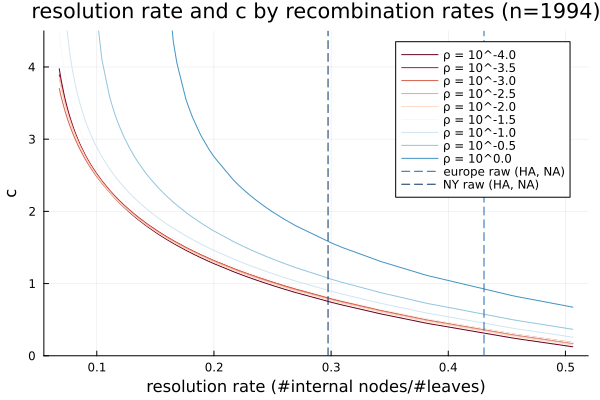

In [101]:
plot_res_c_by_rec(fits, n=1994)

In [102]:
res_154 = (res_NA_NY+res_HA_NY)/2
ran = -4:0.5:0
c_ = []
for rec_rate in ran
    fit = fits[rec_rate]
    append!(c_, -log.(max.(0, fit.(res_154))))
end


In [103]:
res_1994 = (res_NA+res_HA)/2
ran = -4:0.5:0
c_ = []
for rec_rate in ran
    fit = fits[rec_rate]
    append!(c_, -log.(max.(0, fit.(res_1994))))
end

Now it remains to make sure that there have been no changes for the kingman models and that we can continue to use the old $c$ or if this should also be modified. 

In [104]:
using ARGTools, TreeKnit, TreeTools, Plots, StatsBase, CurveFit, Random

function find_c_kingman(;repeat=500, rec_rate = 1, n_nodes=100)
    res_values = Float32[]
    c_values = Float32[]
    for r in 1:repeat 
        rec = 10^rec_rate
        c= rand()
        trees, arg = get_trees(8, n_nodes, remove=true, c =c, ρ = rec, simtype=:kingman);
        rand_ = sample(1:8, 2, replace=false)
        res = [TreeKnit.resolution_value(t) for t in trees[rand_]]
        push!(res_values, sum(res)/2)
        push!(c_values, c)
    end
    return res_values, c_values
end

ran = -4:0.25:0
res_values = Dict()
c_values = Dict() 
for rec_rate in ran
    res_values[rec_rate], c_values[rec_rate] = find_c_kingman(rec_rate=rec_rate)
end

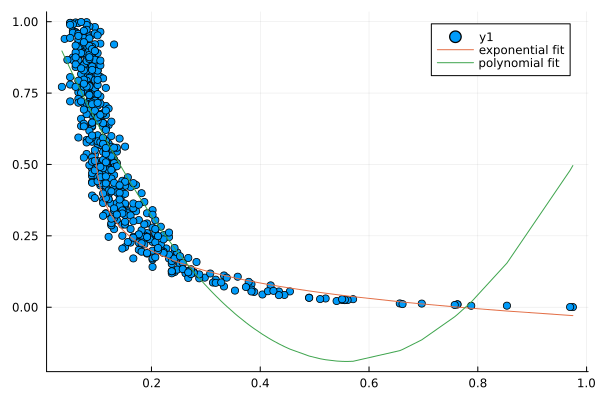

In [105]:

value = 0
plot(scatter(res_values[value], c_values[value]))
fit = curve_fit(LinearFit, res_values[value], 10000 .^-c_values[value])
y0b = max.(0, fit.(sort(res_values[value])))
plot!(sort(res_values[value]), -log10.(y0b)./ log10(10000), label="exponential fit")
fit = curve_fit(Polynomial, res_values[value], c_values[value], 2)
y0b = fit.(sort(res_values[value]))
plot!(sort(res_values[value]), y0b, label="polynomial fit")


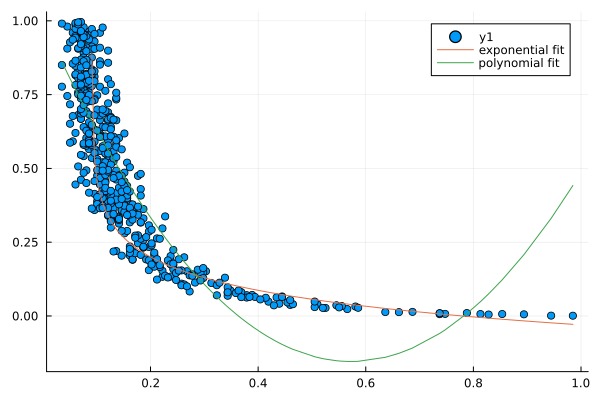

In [106]:
value = -4.0
plot(scatter(res_values[value], c_values[value]))
fit = curve_fit(LinearFit, res_values[value], 10000 .^-c_values[value])
y0b = max.(0, fit.(sort(res_values[value])))
plot!(sort(res_values[value]), -log10.(y0b)./ log10(10000), label="exponential fit")
fit = curve_fit(Polynomial, res_values[value], c_values[value], 2)
y0b = fit.(sort(res_values[value]))
plot!(sort(res_values[value]), y0b, label="polynomial fit")

In [107]:
ran = -4:0.25:0
x = sort(res_values[0.0])
function get_fits_kingman(ran)
    fits = Dict()
    for rec_rate in ran
        fit = curve_fit(LinearFit, res_values[rec_rate], 10000 .^-c_values[rec_rate])
        y = max.(0, fit.(x))
        fits[rec_rate] = fit
    end
    return fits
end
fits = get_fits_kingman(ran)


Dict{Any, Any} with 17 entries:
  -1.75 => LinearFit{Float32}((-0.139334, 1.48799))
  -3.0  => LinearFit{Float32}((-0.142176, 1.5314))
  0.0   => LinearFit{Float32}((-0.135863, 1.48415))
  -1.25 => LinearFit{Float32}((-0.148453, 1.57923))
  -1.0  => LinearFit{Float32}((-0.147383, 1.57017))
  -2.0  => LinearFit{Float32}((-0.139309, 1.52939))
  -0.25 => LinearFit{Float32}((-0.137163, 1.48301))
  -0.5  => LinearFit{Float32}((-0.142253, 1.561))
  -3.25 => LinearFit{Float32}((-0.14078, 1.54978))
  -3.5  => LinearFit{Float32}((-0.146653, 1.57938))
  -2.25 => LinearFit{Float32}((-0.137127, 1.51593))
  -3.75 => LinearFit{Float32}((-0.146801, 1.5661))
  -2.5  => LinearFit{Float32}((-0.141685, 1.53527))
  -0.75 => LinearFit{Float32}((-0.137039, 1.51089))
  -1.5  => LinearFit{Float32}((-0.138386, 1.51598))
  -4.0  => LinearFit{Float32}((-0.131607, 1.45086))
  -2.75 => LinearFit{Float32}((-0.149954, 1.57232))

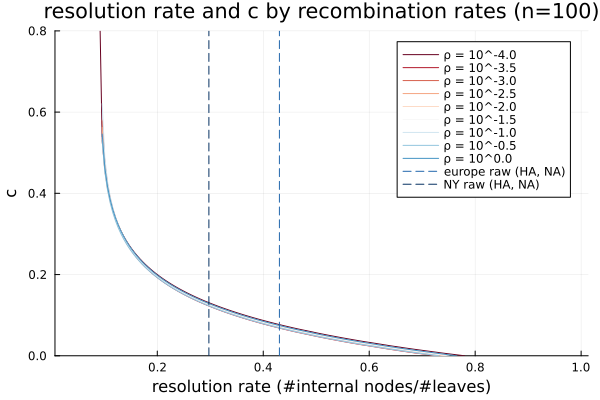

In [108]:
using DataFrames
function plot_res_c_by_rec_kingman(fits; n=100)
    value = -4.0
    x = sort(res_values[value])
    y0b = Vector{Float32}[]
    for rec_rate in -4:0.5:0
        fit =fits[rec_rate]
        y = max.(0, fit.(x))
        append!(y0b, [-log.(y) ./ log(10000)])
    end
    colnames = ["ρ = 10^"*string(r) for r in -4:0.5:0]
    df = DataFrame(y0b, :auto)
    rename!(df, Symbol.(colnames))
    my_cgrad = cgrad(:thermal, rev = true)
    p = plot(x, Matrix(df), xlabel="resolution rate (#internal nodes/#leaves)", ylabel="c", label =hcat(names(df)...), title="resolution rate and c by recombination rates (n="*string(n)*")", palette = :RdBu, ylim=(0, 0.8))
    plot!([(res_NA+res_HA)/2], seriestype="vline", label="europe raw (HA, NA)", linestyle=:dash)
    plot!([(res_NA_NY+res_HA_NY)/2], seriestype="vline", label="NY raw (HA, NA)", linestyle=:dash)
end
plot_res_c_by_rec_kingman(fits)

It appears that in the Kingman model $c$ and resolution rate are relatively independent of the rate of recombination - however it appears in the current 8 segment set up we must take a far smaller value than previously used. As this fit is not as good as the fit for the flu model, I shall quickly check the resolution rate of values around 0.088.

In [109]:
res_1994 = (res_NA+res_HA)/2
res_154 = (res_NA_NY+res_HA_NY)/2
fit = fits[0]
print("The c value needed for res rate (100 leaves)" * string(res_1994)*" is: "*string(-log10(fit.(res_1994)) /log10(10000))*"\n")
print("The c value needed for res rate (100 leaves)" * string(res_154)*" is: "*string(-log10(fit.(res_154)) /log10(10000))*"\n")
print("The c value needed for res rate (100 leaves)" * string(0.3)*" is: "*string(-log10(fit.(0.3)) /log10(10000))*"\n")
print("The c value needed for res rate (100 leaves)" * string(0.35)*" is: "*string(-log10(fit.(0.35)) /log10(10000))*"\n")
print("The c value needed for res rate (100 leaves)" * string(0.4)*" is: "*string(-log10(fit.(0.4)) /log10(10000))*"\n")

The c value needed for res rate (100 leaves)0.4305067737079779 is: 0.074592559838133
The c value needed for res rate (100 leaves)0.2973856209150327 is: 0.12874705183342416
The c value needed for res rate (100 leaves)0.3 is: 0.12737675685355038
The c value needed for res rate (100 leaves)0.35 is: 0.10403380477645548
The c value needed for res rate (100 leaves)0.4 is: 0.08483222317326503


In [110]:
no_lineages = 100
tree_kingman, arg = get_trees(8, no_lineages; remove=true, c=0.75, ρ = 10^(-1), N = 10_000, simtype=:kingman)
TreeTools.ladderize!(tree_kingman[1])
write_newick("test_kingman.nwk", tree_kingman[1])
tree_flu, arg = get_trees(8, no_lineages; remove=true, c=1.5, ρ = 10^(-1), N = 10_000, simtype=:flu)
TreeTools.ladderize!(tree_flu[1])
write_newick("test_flu.nwk", tree_flu[1])
print("res rate kingman:"*string(sum([TreeKnit.resolution_value(t) for t in tree_kingman])/8))
print("res rate flu:"*string(sum([TreeKnit.resolution_value(t) for t in tree_flu])/8))

res rate kingman:0.0744949494949495res rate flu:0.3017676767676768

I shall now do these same simulations for n=100 to calculate the best value of c for every reassortment rate and resolution rate 0.3, 0.35 and 0.4.

In [111]:
function find_c(;repeat=1000, rec_rate = 1, n_nodes=100)
    res_values = Float32[]
    c_values = Float32[]
    for r in 1:repeat 
        rec = 10^rec_rate
        c=0.5 + 4*rand()
        trees, arg = get_trees(8, n_nodes, remove=true, c =c, ρ = rec);
        rand_ = sample(1:8, 2, replace=false)
        res = [TreeKnit.resolution_value(t) for t in trees[rand_]]
        push!(res_values, sum(res)/2)
        push!(c_values, c)
    end
    return res_values, c_values
end

ran = -4:0.25:0
res_values = Dict()
c_values = Dict() 
for rec_rate in ran
    res_values[rec_rate], c_values[rec_rate] = find_c(rec_rate=rec_rate)
end

In [112]:
ran = -4:0.25:0
x = res_values[0.0]
function get_fits(res_values, c_values, ran)
    fits = Dict()
    for rec_rate in ran
        fit = curve_fit(LinearFit, res_values[rec_rate], ℯ.^-c_values[rec_rate])
        y = max.(0, fit.(x))
        fits[rec_rate] = fit
    end
    return fits
end
fits = get_fits(res_values, c_values, ran)

Dict{Any, Any} with 17 entries:
  -1.75 => LinearFit{Float32}((-0.173893, 1.40894))
  -3.0  => LinearFit{Float32}((-0.168974, 1.3844))
  0.0   => LinearFit{Float32}((-0.296914, 1.18054))
  -1.25 => LinearFit{Float32}((-0.170742, 1.33936))
  -1.0  => LinearFit{Float32}((-0.185986, 1.37049))
  -2.0  => LinearFit{Float32}((-0.173835, 1.41276))
  -0.25 => LinearFit{Float32}((-0.247436, 1.22325))
  -0.5  => LinearFit{Float32}((-0.210374, 1.26033))
  -3.25 => LinearFit{Float32}((-0.171168, 1.41323))
  -3.5  => LinearFit{Float32}((-0.164955, 1.37558))
  -2.25 => LinearFit{Float32}((-0.171897, 1.41588))
  -3.75 => LinearFit{Float32}((-0.16955, 1.3952))
  -2.5  => LinearFit{Float32}((-0.167606, 1.40293))
  -0.75 => LinearFit{Float32}((-0.193384, 1.32473))
  -1.5  => LinearFit{Float32}((-0.175239, 1.38665))
  -4.0  => LinearFit{Float32}((-0.167157, 1.39465))
  -2.75 => LinearFit{Float32}((-0.171538, 1.41488))

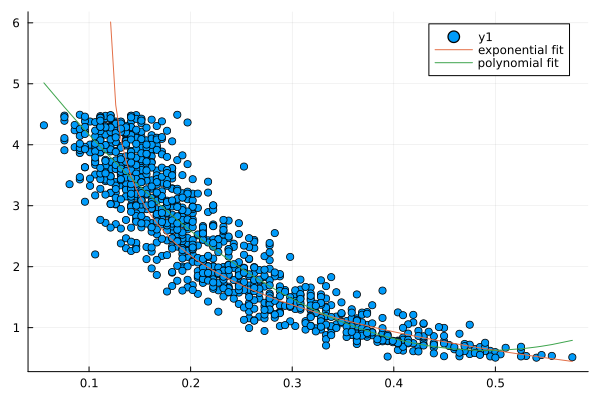

In [113]:
using Plots
using CurveFit

value = -2.5
plot(scatter(res_values[value], c_values[value]))
fit = curve_fit(LinearFit, res_values[value], ℯ.^-c_values[value])
y0b = max.(0, fit.(sort(res_values[value])))
plot!(sort(res_values[value]), -log.(y0b), label="exponential fit")
fit = curve_fit(Polynomial, res_values[value], c_values[value], 2)
y0b = fit.(sort(res_values[value]))
plot!(sort(res_values[value]), y0b, label="polynomial fit")

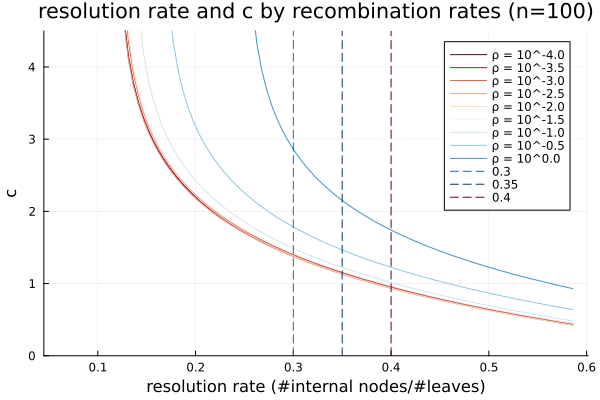

In [114]:
using DataFrames
function plot_res_c_by_rec(fits; n=100)
    value = -4.0
    x = sort(res_values[value])
    y0b = Vector{Float32}[]
    for rec_rate in -4:0.5:0
        fit =fits[rec_rate]
        y = max.(0, fit.(x))
        append!(y0b, [-log.(y)])
    end
    colnames = ["ρ = 10^"*string(r) for r in -4:0.5:0]
    df = DataFrame(y0b, :auto)
    rename!(df, Symbol.(colnames))
    my_cgrad = cgrad(:thermal, rev = true)
    p = plot(x, Matrix(df), xlabel="resolution rate (#internal nodes/#leaves)", ylabel="c", label =hcat(names(df)...), title="resolution rate and c by recombination rates (n="*string(n)*")", palette = :RdBu, ylim=(0, 4.5))
    plot!([0.3], seriestype="vline", label="0.3", linestyle=:dash)
    plot!([0.35], seriestype="vline", label="0.35", linestyle=:dash)
    plot!([0.4], seriestype="vline", label="0.4", linestyle=:dash)
end
plot_res_c_by_rec(fits)

In [115]:
using DataFrames, CSV
function c_value_df(fits)
    y_full = Vector{Float64}[]
    append!(y_full, [-4:0.25:0])
    for c in [0.3, 0.35, 0.4]
        y_ = Float64[]
        for rec_rate in -4:0.25:0
            fit =fits[rec_rate]
            y = max(0, fit(c))
            append!(y_, [-log(y)])
        end
        append!(y_full, [y_])
    end
    colnames = ["rec_rate", "res_0.3", "res_0.35", "res_0.4"]
    df = DataFrame(y_full, :auto)
    rename!(df, Symbol.(colnames))
    return df
end

df = c_value_df(fits)
CSV.write("influenza_c_values_100.txt", df, header=true)

ran = -4:0.25:0
res_values = Dict()
c_values = Dict() 
for rec_rate in ran
    res_values[rec_rate], c_values[rec_rate] = find_c(rec_rate=rec_rate, n_nodes=50)
end
fits = get_fits(res_values, c_values, ran)
df = c_value_df(fits)
CSV.write("influenza_c_values_50.txt", df, header=true)

"influenza_c_values_50.txt"

Let us also find the correct c values for kingman at n=50.

In [116]:
res_values, c_values = find_c_kingman(rec_rate=0.0, n_nodes=50)
plot(scatter(res_values, c_values))
fit = curve_fit(LinearFit, res_values, 10000 .^-c_values)
y0b = max.(0, fit.(sort(res_values)))
plot!(sort(res_values), -log10.(y0b)./ log10(10000), label="exponential fit")
print("The c value needed for res rate (50 leaves)" * string(0.3)*" is: "*string(-log10(fit.(0.3)) /log10(10000))*"\n")
print("The c value needed for res rate (50 leaves)" * string(0.35)*" is: "*string(-log10(fit.(0.35)) /log10(10000))*"\n")
print("The c value needed for res rate (50 leaves)" * string(0.4)*" is: "*string(-log10(fit.(0.4)) /log10(10000))*"\n")

The c value needed for res rate (50 leaves)0.3 is: 0.18107917876236396
The c value needed for res rate (50 leaves)0.35 is: 0.14883145463757763
The c value needed for res rate (50 leaves)0.4 is: 0.12400063359264915
